# Plotting Fraunhofer Lines



## This is what I'm supposed to do: 

1. Deblaze and normalize the data by dividing out the echelle blaze function
2. Transform the wavelength solution of the data to constant RV space
3. Download a corresponding synthetic or empirical spectrum and transform its wavelength solution to constant RV space
4. Run a chi-squared test on the data and the empirical spectrum to determine doppler shift
5. Shift the data to be in the rest frame

hello, alicia from the future here, after some long time debugging, it seems that the NEID dataset had some nan values for the flux range that i cared about. so in an attempt to fix things, i am tossing this dataset and trying another one. 

### doing 0: reducing the spectra to be 1D:


In [1]:
#importing recommended libraries: 

from astropy.io import fits
import matplotlib.pylab as plt
import numpy as np
import scipy.interpolate
from scipy.interpolate import splev, splrep

In [2]:
import seaborn as sns
sns.set_theme()

In [3]:
''' HDUL files are  logical header/data units (HDU) which i think just gives a 
table that has units that are assigned to each column? '''

' HDUL files are  logical header/data units (HDU) which i think just gives a \ntable that has units that are assigned to each column? '

## for importing data, im supposed to use NEID 

use the following link: 

<https://neid.ipac.caltech.edu/search.php>

if it doesnt do it automatically, the object is HD 10700 and the data level is 1 

>The wavelength range for NA I lines is 4700-6000 angstroms (470-600 nm) 

I'm not sure where I found that wavelength range information since the internet says a much smaller range centered at around 5800 angstroms 

In [4]:
#reading in data and assigning it to arrays 
#for windows, the path needs double backslashes when copying as a location

star = 'HD 10700' 
data_path = "C:\\Users\\alica\\workspace\\Intro-2-Spectra\\analysis\\NEID_analysis\\neidL1_20220118T015112.fits"
# APF_flux_path = '/datag/blpd0/datax/apf/rarj.224.fits'

file = fits.open(data_path)
# fl_file = fits.open(APF_flux_path)
wl_image = file['SCIWAVE'].data
fl_image = file['SCIFLUX'].data

#so far I am only working with one file

In [5]:
file.info() #this just reads the table values in a simplifed format

Filename: C:\Users\alica\workspace\Intro-2-Spectra\analysis\NEID_analysis\neidL1_20220118T015112.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     745   ()      
  1  SCIFLUX       1 ImageHDU        12   (9216, 122)   float64   
  2  SKYFLUX       1 ImageHDU        12   (9216, 122)   float64   
  3  CALFLUX       1 ImageHDU        12   (9216, 122)   float64   
  4  SCIVAR        1 ImageHDU        12   (9216, 122)   float32   
  5  SKYVAR        1 ImageHDU        12   (9216, 122)   float32   
  6  CALVAR        1 ImageHDU        12   (9216, 122)   float32   
  7  SCIWAVE       1 ImageHDU      2451   (9216, 122)   float64   
  8  SKYWAVE       1 ImageHDU      2451   (9216, 122)   float64   
  9  CALWAVE       1 ImageHDU      2451   (9216, 122)   float64   


In [6]:
# c = 0
# for i in wl_image:
#     print('row #',c,i)
#     c+=1

Below is the given graph for the wavelength vs pixel count off of the NEID archive for the fits file i am using

In [7]:
#through observation imma go with row 69 since it seems to fit within the range we want 
#imma call this run through trial2 for future variable assignments, or maybe ill just make a new notebook idk

### Discontinuities (nan values)
I noticed there were some undefined values in the data set, so I am going to change those to be real values. Since its a chunk that is in a wavelgnth that I am not concerned with, I am going to just assign them to be the mean of the 4 neighboring data points at either end of the chunk. 

the discontinuities are in the flux, so the wavelenghts are fine. as long as we dont remove any data points
and just change their values there shouldn't be any issues with the array lenghts and plotting (Famous last words?)

In [8]:
#test: change the nan to continue the pattern 

test_nan = np.array([0,1,2,np.nan,np.nan,5,6])
test_nan

#this changes the nan values to whatever I set this equal to, 1 would be the move in this case for simplicity.    
test_nan[np.isnan(test_nan)] = 1
test_nan

#okay so this works, im going to try 1 in this case, and then if it all goes smoothly Ill be more
#correct and do the mean in that range! 

array([0., 1., 2., 1., 1., 5., 6.])

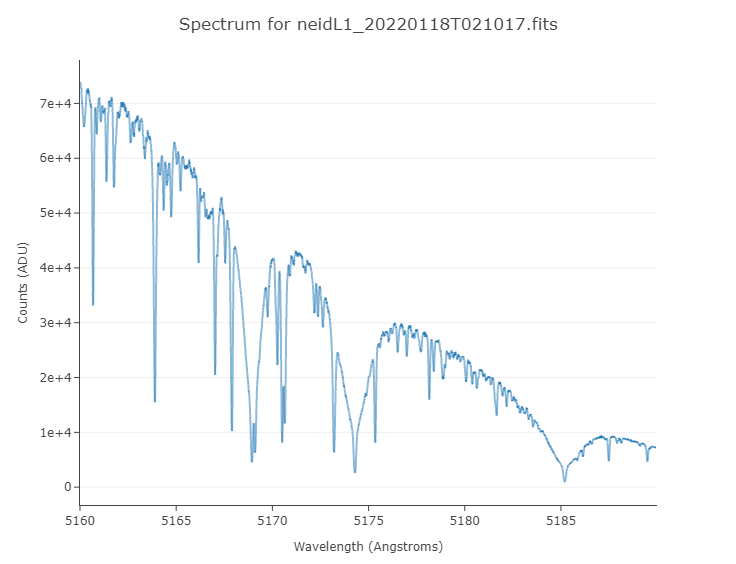

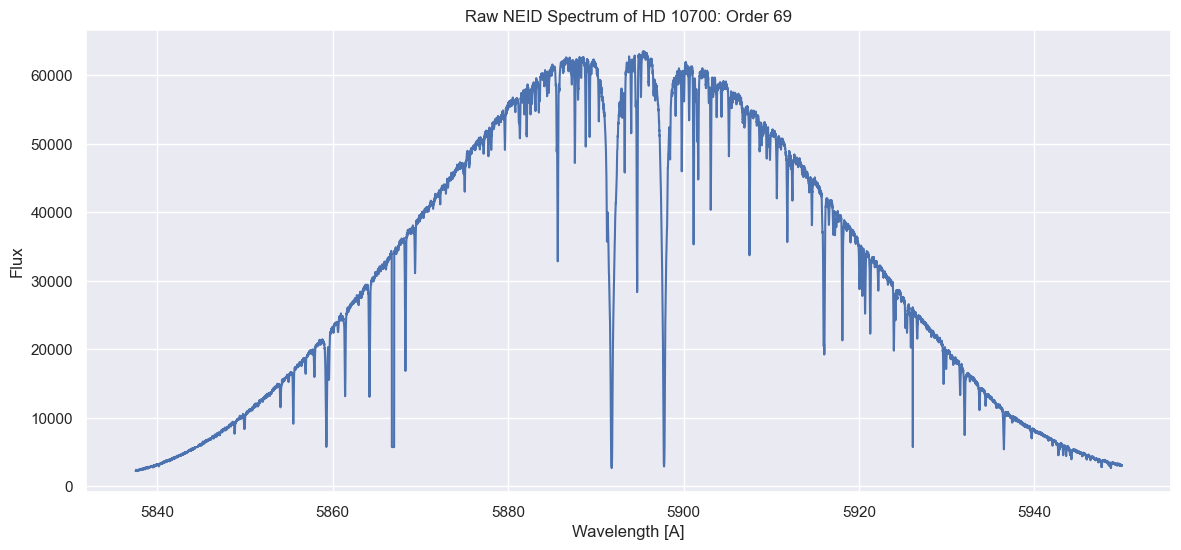

In [9]:
#next block (this plots the raw data hopefully)

plt.rcParams["figure.figsize"] = (14,6)
plt.rcParams.update({'font.size': 20})


order = 69
order1 = 68
order2 = 69

wl = wl_image[order]
flux = fl_image[order] #reassigned below, so this will be fixed -- just making a note --

#replacing nan values 
replacement_flux = np.mean([5671, 5678,5793,5824])
flux[np.isnan(flux)] = replacement_flux #found this through printing the array and finding the neighbors

plt.plot(wl,flux)

plt.title('Raw NEID Spectrum of ' + star + ': Order ' + str(order)) #fix title 
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.show()

#okay so far so good? Looks kinda too bellshaped but maybe thats okie

In [10]:
wl_test = []
for i in range(3,100):
    wl_test.append(wl_image[i])
wl_test

[array([3570.94366863, 3570.95346848, 3570.96326784, ..., 3640.05422442,
        3640.05950614, 3640.06478745]),
 array([3591.94333628, 3591.95345481, 3591.96357246, ..., 3661.51064358,
        3661.51574867, 3661.52085301]),
 array([3613.47983488, 3613.48968308, 3613.49953093, ..., 3683.3519227 ,
        3683.35720102, 3683.36247887]),
 array([3635.09951377, 3635.10952498, 3635.11953554, ..., 3705.2899109 ,
        3705.29496654, 3705.3000213 ]),
 array([3656.83234385, 3656.8427352 , 3656.85312549, ..., 3727.53854074,
        3727.5434735 , 3727.54840515]),
 array([3679.15733719, 3679.16745836, 3679.17757898, ..., 3750.32452337,
        3750.3299075 , 3750.33529112]),
 array([3701.75997064, 3701.76988531, 3701.77979978, ..., 3773.43866104,
        3773.44447589, 3773.45029073]),
 array([3724.37146043, 3724.38160951, 3724.39175812, ..., 3796.33909597,
        3796.34455912, 3796.35002178]),
 array([3747.35868185, 3747.3689156 , 3747.37914884, ..., 3819.76820514,
        3819.77368245, 

In [11]:
#editing flux: 
replacement_flux = np.mean([5671, 5678,5793,5824])
flux[np.isnan(flux)] = replacement_flux #found this through printing the array and finding the neighbors
for i in np.arange(len(flux)): 
    if flux[i] == replacement_flux:
        print(wl[i])
#there are more of these than i thought. ill check on this later . . .

5844.408806572839
5844.42439294148
5844.439978471226
5844.455563162076
5844.471147014029
5844.486730027086
5844.502312201244
5844.517893536505
5844.533474032866
5844.54905369033
5844.564632508893
5844.580210488556
5844.595787629319
5844.61136393118
5844.626939394141
5866.7486326299095
5866.762975609707
5866.777317765934
5866.791659098603
5866.80599960773
5866.820339293326
5866.8346781554055
5866.8490161939835
5866.8633534090695
5866.877689800681
5866.892025368831
5866.90636011353
5866.920694034795
5866.9350271326375
5866.949359407072
5866.96369085811
5866.978021485768
5866.992351290058
5867.006680270993
5926.135285583637


In [12]:
#the wl_image array was empty:

fits.open(data_path).info()

Filename: C:\Users\alica\workspace\Intro-2-Spectra\analysis\NEID_analysis\neidL1_20220118T015112.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     745   ()      
  1  SCIFLUX       1 ImageHDU        12   (9216, 122)   float64   
  2  SKYFLUX       1 ImageHDU        12   (9216, 122)   float64   
  3  CALFLUX       1 ImageHDU        12   (9216, 122)   float64   
  4  SCIVAR        1 ImageHDU        12   (9216, 122)   float32   
  5  SKYVAR        1 ImageHDU        12   (9216, 122)   float32   
  6  CALVAR        1 ImageHDU        12   (9216, 122)   float32   
  7  SCIWAVE       1 ImageHDU      2451   (9216, 122)   float64   
  8  SKYWAVE       1 ImageHDU      2451   (9216, 122)   float64   
  9  CALWAVE       1 ImageHDU      2451   (9216, 122)   float64   


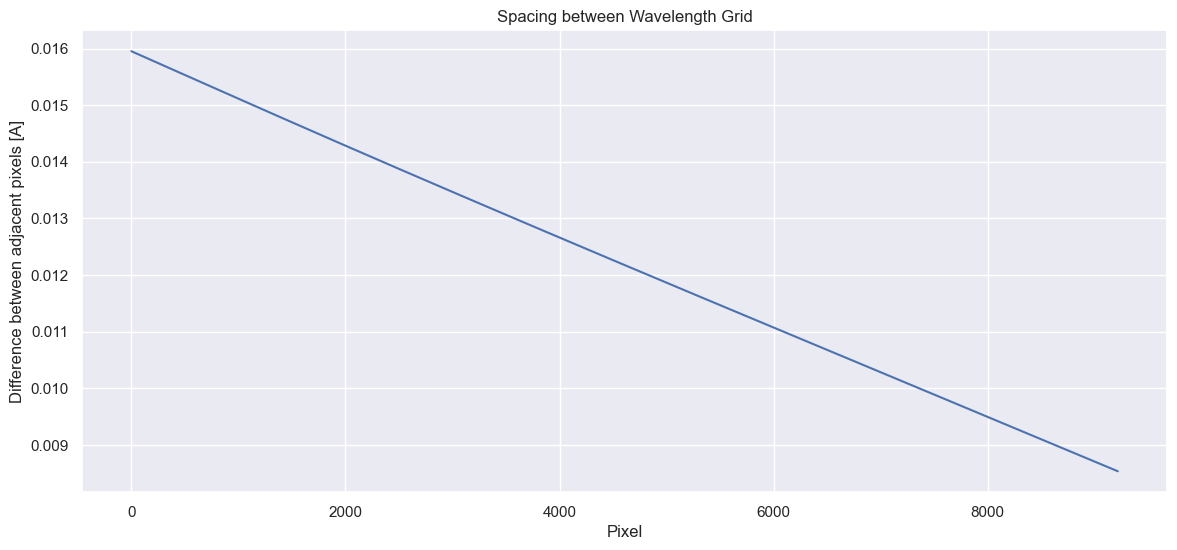

In [13]:
#okie time for the next chunk!
plt.plot(np.arange(len(wl) - 1), (wl[1:] - wl[:-1]))
plt.title('Spacing between Wavelength Grid')
plt.xlabel('Pixel')
plt.ylabel('Difference between adjacent pixels [A]')
plt.show()

# Spacing between pixels decreases at greater wavelengths.
#this isnt chunky like the same one, but hopefully thats okie?

# part 1: Dividing out the Echelle Blaze Function
## NOTE: I still need to fully understand what Im coding in this section 

Information for what the Echelle Blaze Function even is:

<https://en.wikipedia.org/wiki/Blazed_grating>

### Objective: 
>Divide the data into bins of 100 pixels. Find the flux value in the 95th percentile within each bin and plot these flux values onto the wavelength values. Divide the APF flux spectrum by the fit of the 95th percentile flux values.

From what i understand from that, is that for each 100 pixels, the "brightest" 5 will make it through and then those get plotted

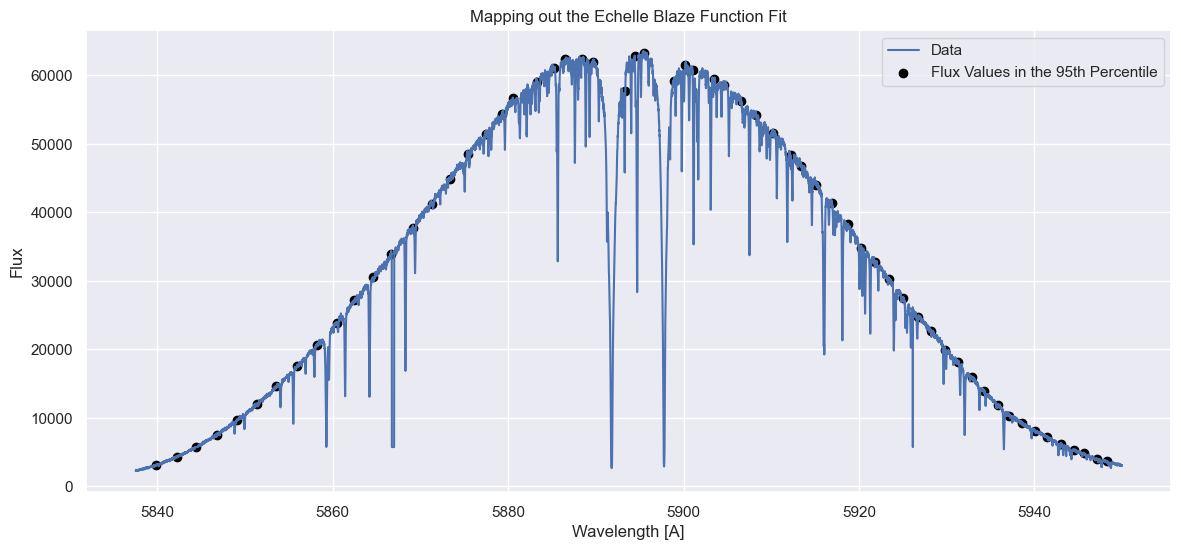

In [14]:
#given code: this feels like cheating lol i gotta go back and understand this fully 

bin = 150 #modifying bins to even out the blaze function better 

# this list will contain the indices corresponding to each of the 95th percentile flux values in each bin
indices = []

for i in np.arange((len(wl) - (bin)), step = bin):
    flux_values = []
    for j in np.arange(i, i + bin, step = 1):
        value = flux[j]
        flux_values = np.append(flux_values, value)
    # find the 95th percentile flux value: we use 95 to get the maximum flux value in general 
    # but avoid issues with cosmic rays and other emission lines
    flux_in_bin = np.percentile(flux_values, 95)
    # find the closest value in the flux array to the 95th percentile value
    absolute_difference_function = lambda list_value : abs(list_value - flux_in_bin)
    flux_in_bin = min(flux_values.tolist(), key=absolute_difference_function)
    index_in_bin = flux_values.tolist().index(flux_in_bin)
    index = i + index_in_bin
    indices = np.append(indices, index)

# these lists will contain the wavlength and flux values at each index in 'indices'
wl_values = []
fl_values = []

for index in indices:
    ind = int(index)
    wl_values = np.append(wl_values, wl[ind])
    fl_values = np.append(fl_values, flux[ind])
    
plt.plot(wl, flux, label = 'Data')
plt.scatter(wl_values, fl_values, color = 'black', label = 'Flux Values in the 95th Percentile')
plt.title('Mapping out the Echelle Blaze Function Fit')
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.legend()
plt.show()

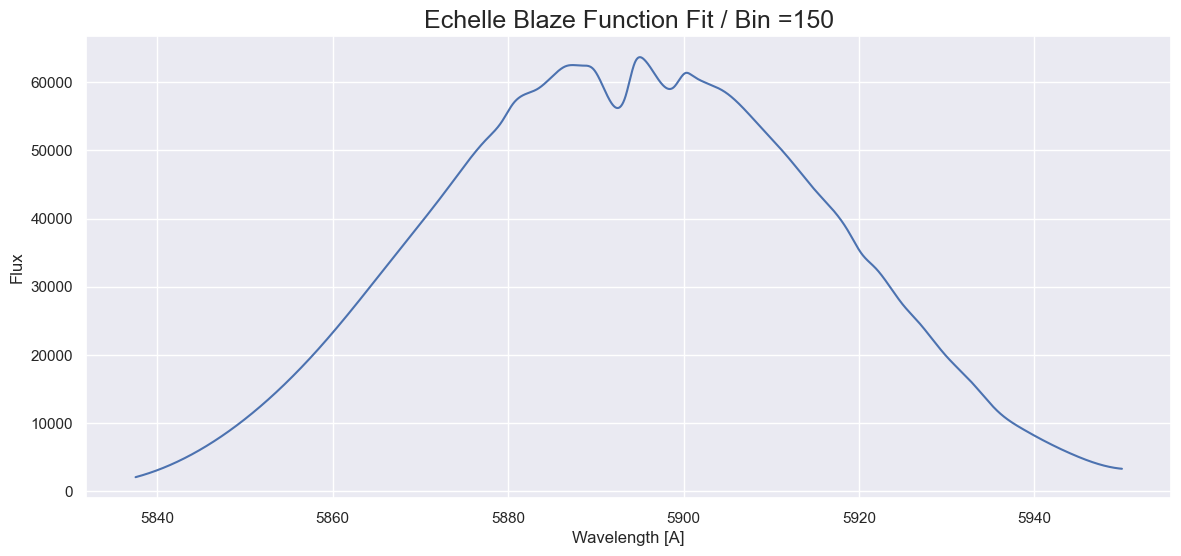

In [15]:
#Plot fl_values onto wl_values so that the length of the arrays match that of the APF spectrum. 
#Set s to 500000 to smooth the fit.

spl = splrep(wl_values, fl_values, s = 500000) #uses a B-Spline fitting method 
flux_fit = splev(wl, spl)
plt.plot(wl, flux_fit)
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.title('Echelle Blaze Function Fit / Bin =' + str(bin), fontsize = 18)
plt.show()

#smooth this out 

B-Spline fitting information: (scipy.interpolate.splrep)

<https://en.wikipedia.org/wiki/B-spline>

<https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.splrep.html>

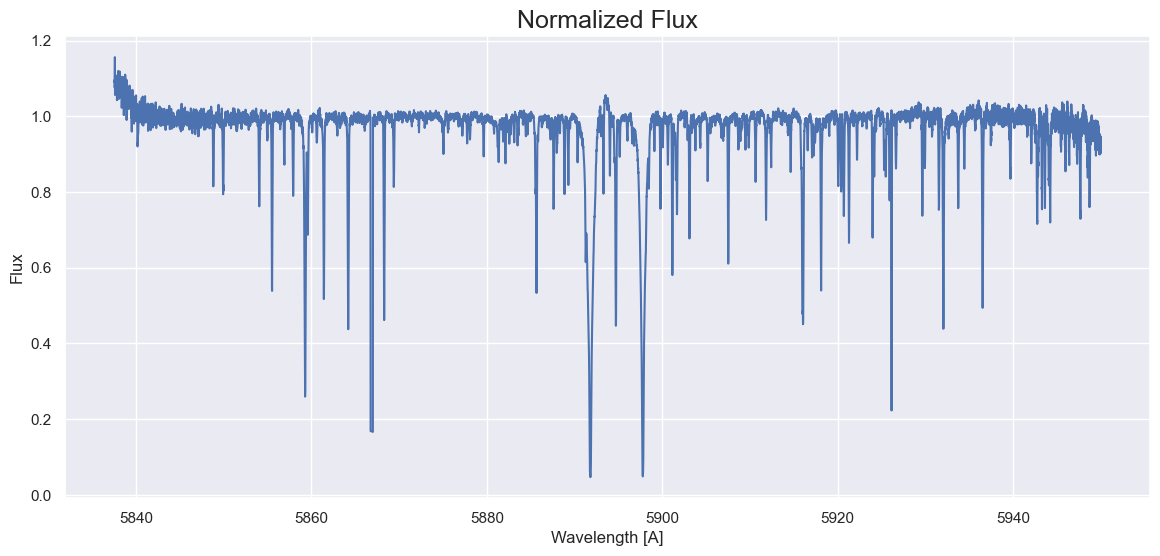

In [16]:
#this is supposed to divide the fit from the data and make it normalized

first_normalized_flux = flux / flux_fit
plt.plot(wl, first_normalized_flux)
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.title('Normalized Flux',fontsize = 18)
plt.show()

## Normalize again

95th percentile isnt thebest we can do, so normalizing again but in this time to the 98th percentile and then divide again. 

ensures its normalized to 1

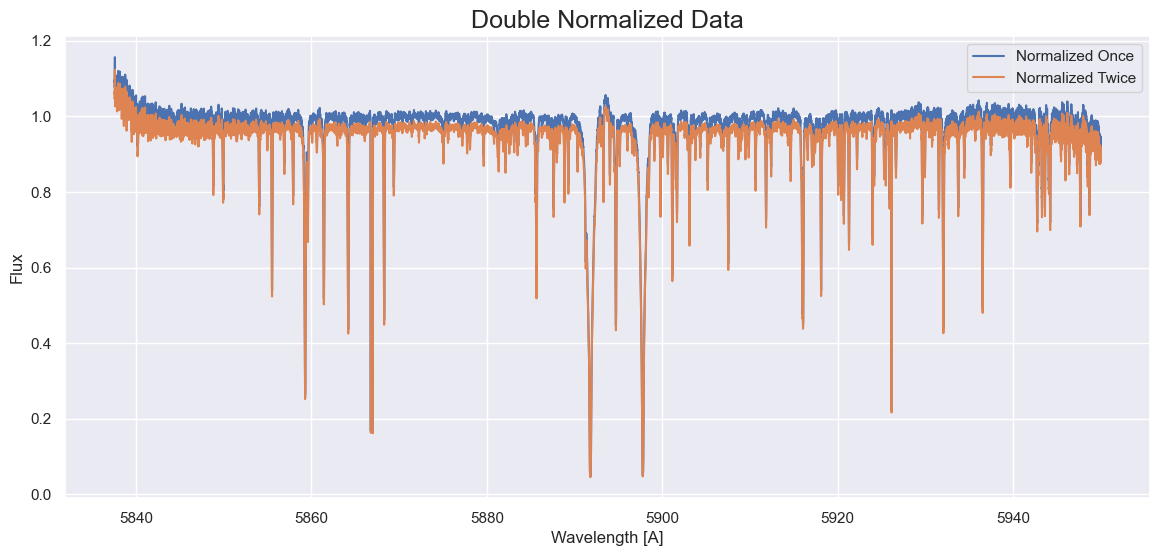

In [63]:
flux98 = np.nanpercentile(first_normalized_flux, 98) #fixed the bug mentioned below 
normalized_flux = first_normalized_flux / flux98

plt.plot(wl, first_normalized_flux, label = 'Normalized Once')
plt.plot(wl, normalized_flux, label = 'Normalized Twice')
plt.legend()
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.title('Double Normalized Data', fontsize = 18)
plt.show()

### now this isnt printing the second normalization, so that means we need to do some debugging! 

flux98 isnt getting any values. now why is that?

even an array of zeros makes more sense than whats happening, so where is the error?

Found it lol: 

<https://stackoverflow.com/questions/30836032/why-does-np-percentile-return-nan-for-high-percentiles>

the percentile was so high that np.percentile considered them infinite and assigned them to be nan. using nanpercentile overrides that.

>this raises the question as to why Zoe's data didnt have that issue but mine did. . .

## Part 2: Regriding the Wavelength Grid to be in Constant RV Space

Plot the normalized flux values onto the original wavelength grid, create a new wavelength grid that is log lambda spaced, and then interpolate onto the new wavelength grid. This will create a spectrum that is in constant RV space, which will allow for a straightforward calculation of the Doppler shift.


In [18]:
f = scipy.interpolate.interp1d(wl, normalized_flux, kind='cubic')

#note: breaks down if quadratic or cubic 

In [19]:
#create an array of wavelength values that are spaced apart on a log scale (in order to change it to velocity)
dv = 1 # km/s  (?) why did she choose 1? 
C = 299792.458 #km/s
wl_start = min(wl) + 0.2
wl_end = max(wl) - 0.2

CDELT1 = np.log10(dv/C +1) # wavelength grid step size

CRVAL1 = np.log10(wl_start)  # log of starting wavelength value
CRVALN = np.log10(wl_end)    # log of ending wavelength value 
NAXIS1 = (CRVALN - CRVAL1) / CDELT1  # total number of points

p = np.arange(NAXIS1) # array of total points
wl2 = 10 ** (CRVAL1 + CDELT1 * p)  # new array of wavelength values

# interpolate flux values onto log spaced wavelength grid
flux2 = f(wl2)

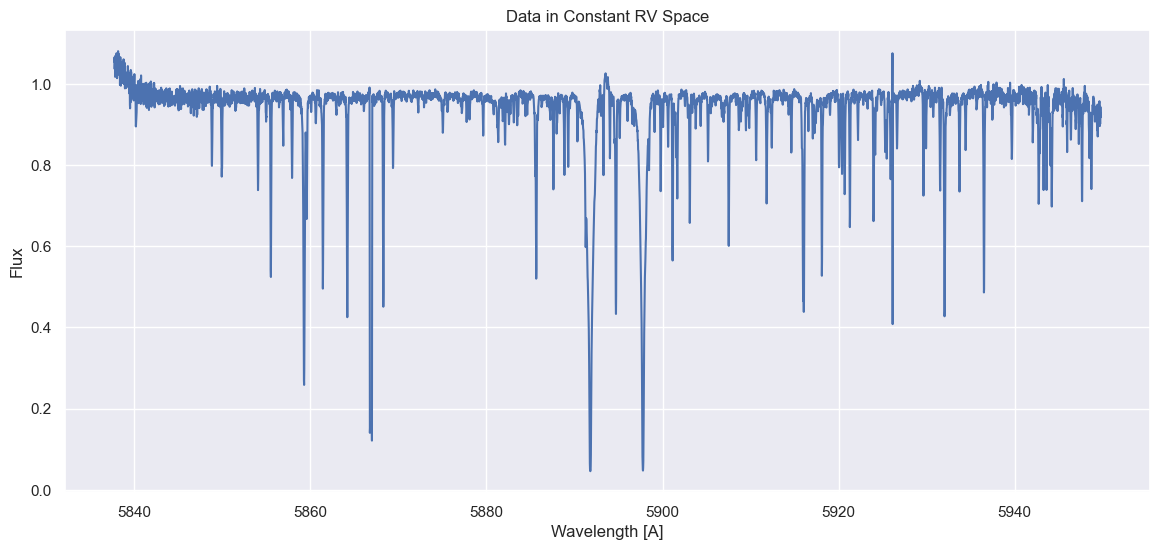

In [20]:
#Plot the new wavelength grid against flux values. 
#This should look the same as before; however, the wavelengths are now velocity spaced

plt.plot(wl2, flux2)
#plt.plot(wl,normalized_flux)
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.title('Data in Constant RV Space')
# plt.ylim(0.9,1)
# plt.xlim(4800,4810)
plt.show()

(0.8, 1.1)

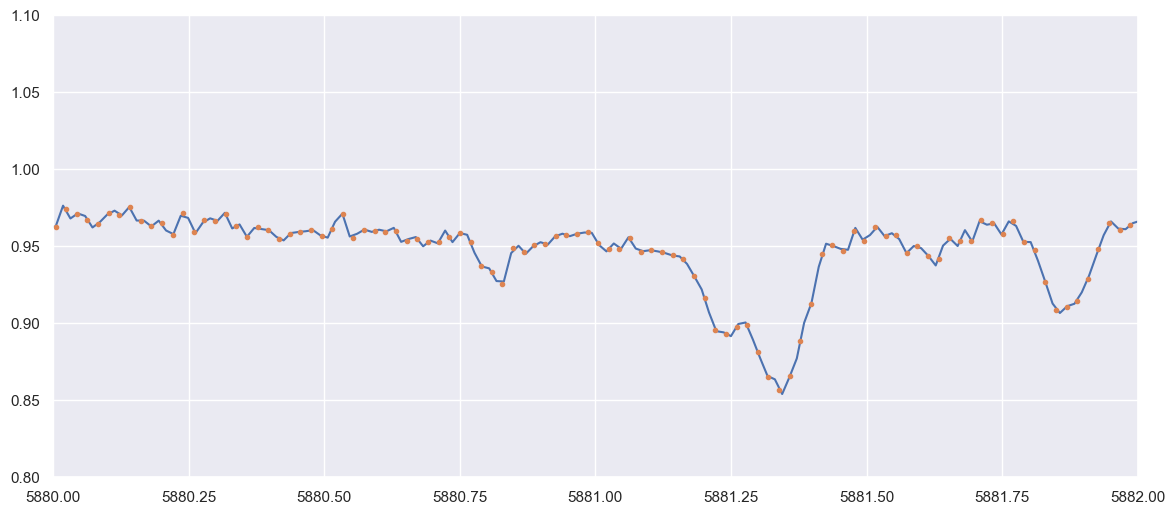

In [21]:
#comparing the shift to see if it makes sense (still unsure)
plt.plot(wl, normalized_flux, '-', wl2, flux2, '.')
plt.xlim(5880,5882)
plt.ylim(0.8,1.1)

In [22]:
len(wl2)

5700

## Part 3: Taking the Sun's spectrum and transforming it to RV Space

Read the empirical solar spectrum using astropy.io.fits. There are two arrays: one is the wavelength from around 3000 angstroms to 12,500 Angstroms, and the second is the corresponding flux array. Truncate it to match the wavelength range of the APF data.

In [23]:
solar_spectrum_path = "C:\\Users\\alica\\workspace\\Intro-2-Spectra\\analysis\\NEID_analysis\\nso.fits"
solar_spectrum = fits.open(solar_spectrum_path)

In [24]:
solar_spectrum.info()

Filename: C:\Users\alica\workspace\Intro-2-Spectra\analysis\NEID_analysis\nso.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   (1097840,)   float64   
  1                1 ImageHDU         6   (1097840,)   float64   


In [25]:
#still need to go over:

wl_temp = solar_spectrum[0].data
fl_temp = solar_spectrum[1].data

# wavelengths of APF data -- turning into my NEID data

#this is giving the starting point of our data set:
min_wl = min(wl2) - 8 #why 8 doe
absolute_difference_function = lambda list_value: abs(list_value-min_wl)
w = min(wl_temp.tolist(), key = absolute_difference_function)
min_index = wl_temp.tolist().index(w)

#this gives the end point:
max_wl = max(wl2) + 8
absolute_difference_function = lambda list_value : abs(list_value - max_wl)
w = min(wl_temp.tolist(), key = absolute_difference_function)
max_index = wl_temp.tolist().index(w)

wl_syn_temp = wl_temp[min_index:max_index] #syn for synthetic?
fl_syn_temp = fl_temp[min_index:max_index]


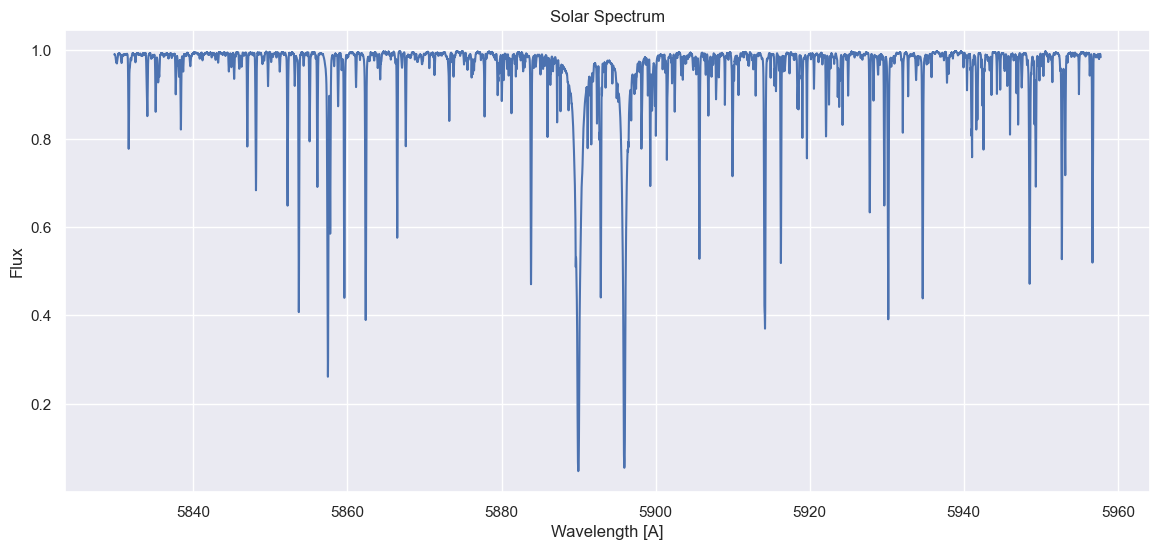

In [26]:
#plotting
plt.plot(wl_syn_temp, fl_syn_temp)
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.title('Solar Spectrum')
plt.show()

this doesn't seem right to me, but just because it looks not like the one in the guide.

I dont have intuition on what the sun's spectrum should really look like in this regard

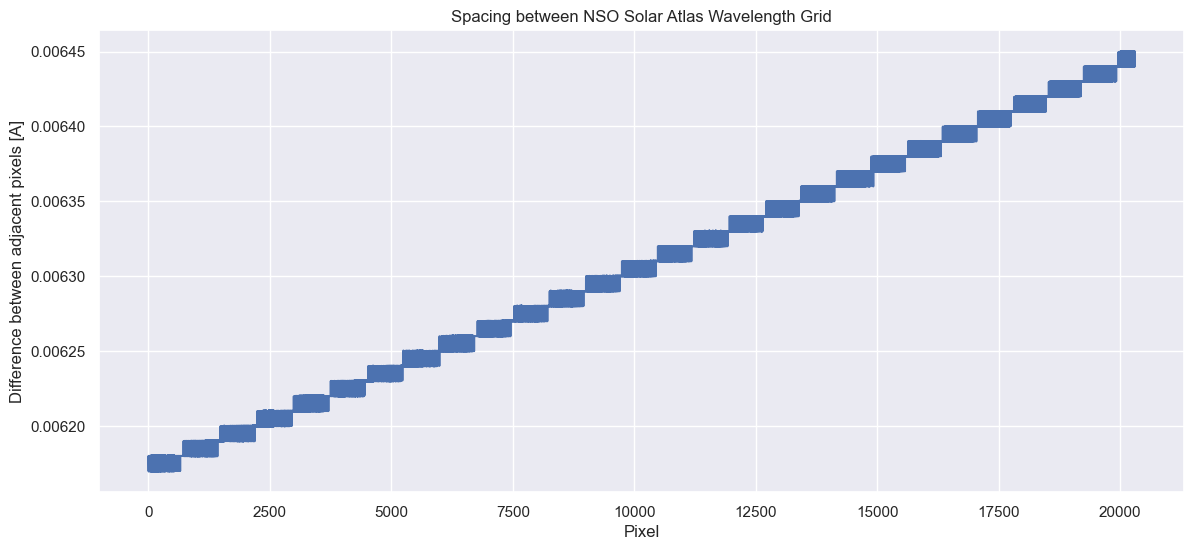

In [27]:
#spacing thing again:
plt.plot(np.arange(len(wl_syn_temp) - 1), (wl_syn_temp[1:] - wl_syn_temp[:-1]))
plt.title('Spacing between NSO Solar Atlas Wavelength Grid')
plt.xlabel('Pixel')
plt.ylabel('Difference between adjacent pixels [A]')
plt.show()

Hey thats right now!


In [28]:
#rinse and repeat:
f = scipy.interpolate.interp1d(wl_syn_temp, fl_syn_temp, kind='cubic')

In [29]:
#create an array of wavelength values that are spaced apart on a log scale (in order to change it to velocity)
dv = 1 #km/s
C = 299792.458 #km/s
wl_start = min(wl_syn_temp) + 0.2
wl_end = max(wl_syn_temp) - 0.2

CDELT1 = np.log10(dv/C +1) #wavelength grid step size

CRVAL1 = np.log10(wl_start)  #log of starting wavelength value
CRVALN = np.log10(wl_end)    #log of ending wavelength value 
NAXIS1 = (CRVALN - CRVAL1) /CDELT1  #total number of points

p = np.arange(NAXIS1) #array of total points
wl_syn = 10 ** (CRVAL1 + CDELT1 * p)  #array of wavelength values

# interpolate flux values onto log spaced wavelength grid
fl_syn = f(wl_syn)

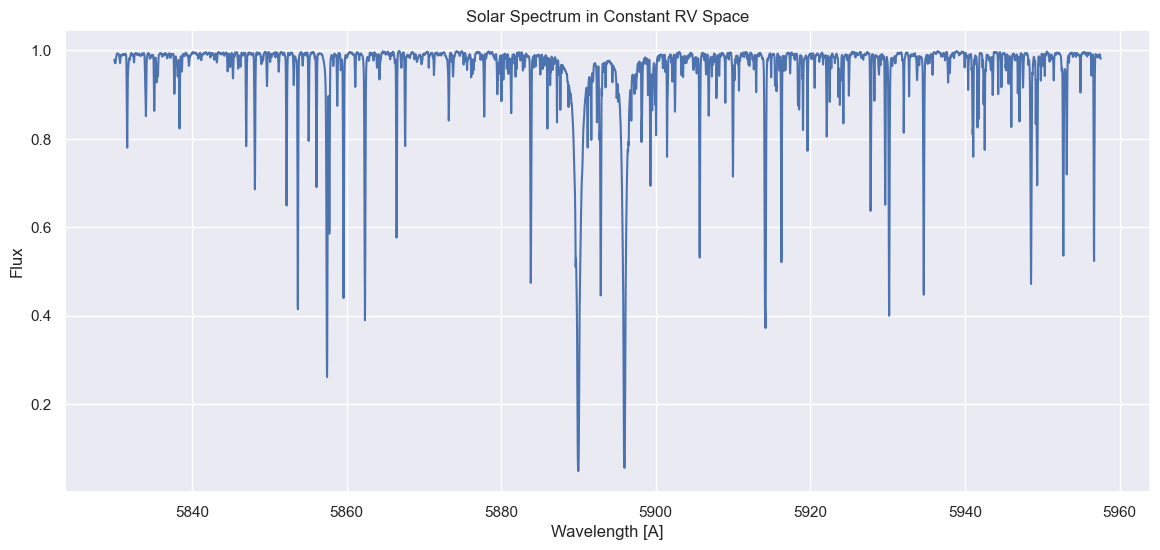

In [30]:
plt.plot(wl_syn, fl_syn)
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.title('Solar Spectrum in Constant RV Space')
plt.show()

### Finding the velocity shift of the data from the empirical spectrum

First find the current offset of the APF spectrum and the empirical spectrum

In [31]:
min_wl = min(wl2) #changed this to wl2, to be the most uptodate version of the data set
absolute_difference_function = lambda list_value : abs(list_value - min_wl)
w = min(wl_syn.tolist(), key = absolute_difference_function)
index = wl_syn.tolist().index(w)

print('The first value of the NEID data is located at pixel ' + str(index) + ' of the empirical spectrum.')

The first value of the NEID data is located at pixel 401 of the empirical spectrum.


In [90]:
#below is not my own code, so i have yet to understand it fully

## Part 4: Chi Squared test to find doppler shift

Run a chi-squared test to determine the offset of the data and the empirical spectrum. The chi-squared test will scan the data against the synthetic spectrum: it will begin where the first pixels of each spectrum line up and end where the last pixels of each spectrum line up. The test will calculate the residual at each location. When the two spectra line up, the residual will be minimized, resulting in a minimum in the chi-squared plot.

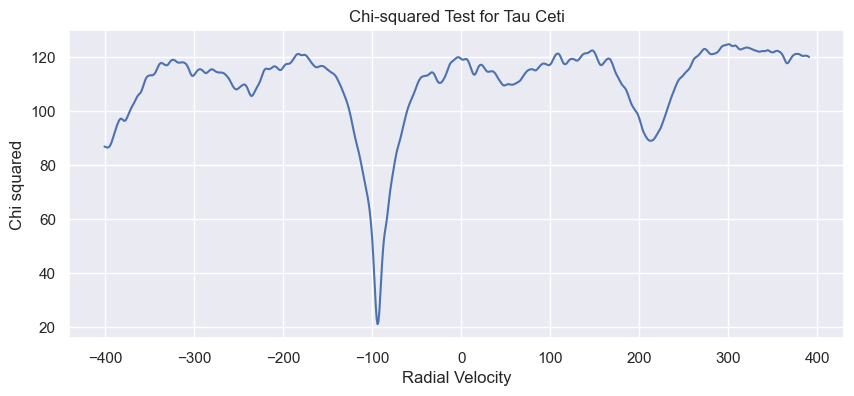

HD 10700 is traveling toward Earth at 94 km/s. The APF spectrum needs to be redshifted by 94 pixels. (Shift to left.)


In [62]:
def chi(model, data):
    '''given two arrays of the same length,
    calculate chi squared'''
    return np.sum((data - model) ** 2)
    
chi_squared_values = []
indices = []

for i in np.arange(len(wl_syn) - len(wl2)): #changing wl to wl2
    syn_flux = fl_syn[i: i + len(wl2)]
    chi_squared = chi(syn_flux, flux2) #changing to flux2
    chi_squared_values = np.append(chi_squared_values, chi_squared)
    indices = np.append(indices, i)
    
min_chi = min(chi_squared_values)
shifted_index = chi_squared_values.tolist().index(min_chi)

plt.figure(figsize = (10,4))
plt.plot(indices - index, chi_squared_values)
plt.xlabel('Radial Velocity')
plt.ylabel('Chi squared')
plt.title('Chi-squared Test for Tau Ceti')
plt.show()

if (shifted_index - index) < 0:
    shift = index - shifted_index
    print(star + ' is traveling toward Earth at ' + str(shift) + ' km/s. The APF spectrum needs to be redshifted by ' + str(shift) + ' pixels. (Shift to left.)')
    shift_dir = 'left'
else:
    shift = shifted_index - index
    print(star + ' is traveling away from Earth at ' + str(shift) + ' km/s. The APF spectrum needs to be blueshifted by ' + str(shift) + ' pixels. (Shift to right.)')
    shift_dir = 'right'

The minimum chi-squared value occurs where the residual between the data and the empirical spectrum is minimized, indicating a best fit. The noise around this minimum represent RV values where the data happens to fit better or worse with the empirical spectrum.

Make a plot of the unshifted APF spectrum against the empirical spectrum.

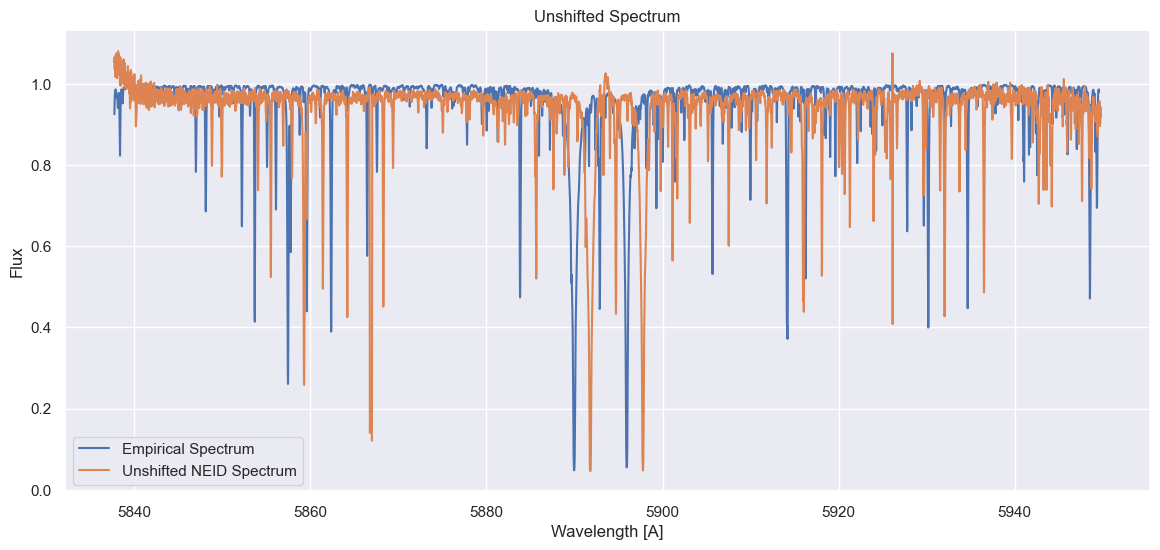

In [35]:
#okay so far so good!

wl_syn_plot = wl_syn[index:-index]
fl_syn_plot = fl_syn[index:-index]

if shift_dir == 'left':
    shifted_wl = wl2[:-shift]
    shifted_fl = flux2[shift:]
else:
    shifted_wl = wl2[shift:]
    shifted_fl = flux2[:-shift]

plt.plot(wl_syn_plot, fl_syn_plot, label = 'Empirical Spectrum')
plt.plot(wl2, flux2, label = 'Unshifted NEID Spectrum')

plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.title('Unshifted Spectrum')
plt.legend()
plt.show()

Zoom in to a smaller region of the plot to better visualize the offset between the data and the empirical spectrum.

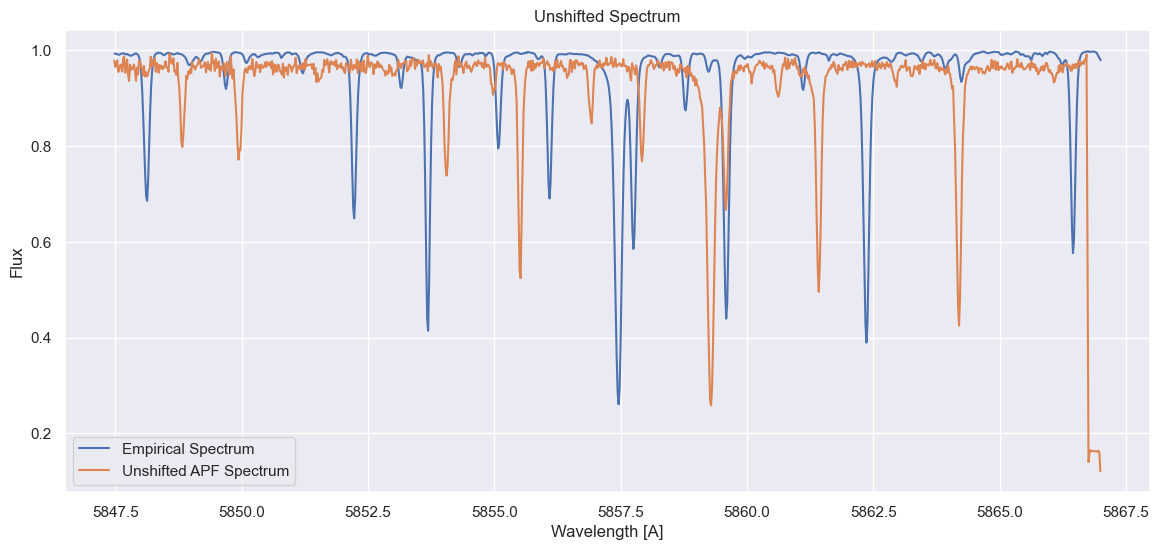

In [36]:
wl_syn_plot = wl_syn[index:-index]
fl_syn_plot = fl_syn[index:-index]

if shift_dir == 'left':
    shifted_wl = wl2[:-shift]
    shifted_fl = flux2[shift:]
else:
    shifted_wl = wl2[shift:]
    shifted_fl = flux2[:-shift]
a = 500
b = 1500

plt.plot(wl_syn_plot[a:b], fl_syn_plot[a:b], label = 'Empirical Spectrum')
plt.plot(wl2[a:b], flux2[a:b], label = 'Unshifted APF Spectrum')

plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.title('Unshifted Spectrum')
plt.legend()
plt.show()

Plot the residuals.

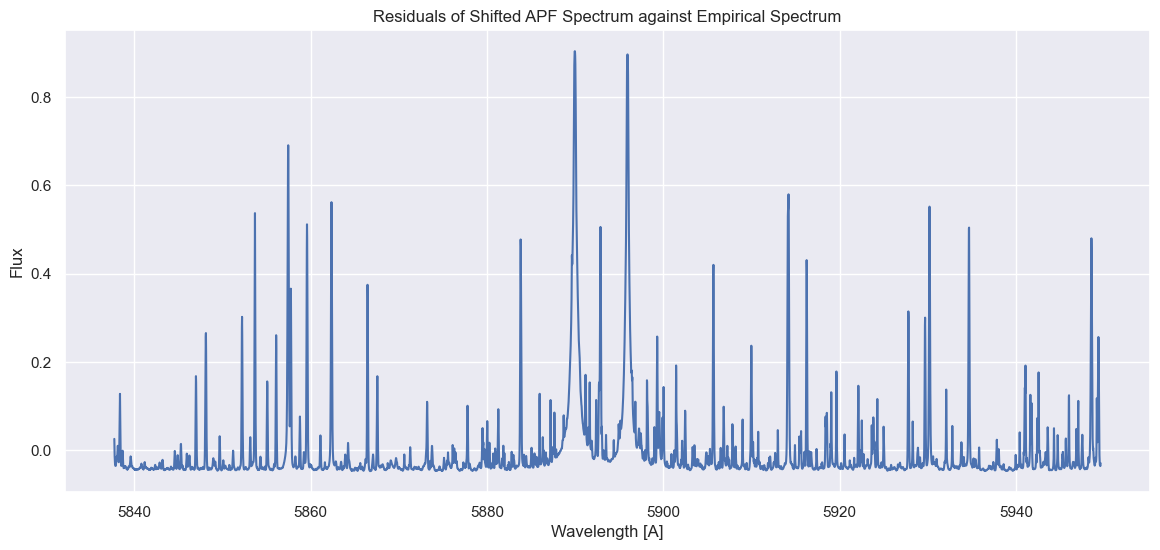

The average residual is -0.0024859439646866058


In [37]:
residuals_unshifted = flux2[len(wl_syn_plot)] - fl_syn_plot
plt.plot(wl_syn_plot, residuals_unshifted)
 
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.title('Residuals of Shifted APF Spectrum against Empirical Spectrum')
plt.show()

print('The average residual is ' + str(np.average(residuals_unshifted)))

Now make a plot of the shifted APF spectrum against the empirical spectrum. The data should line up with the empirical spectrum much better.

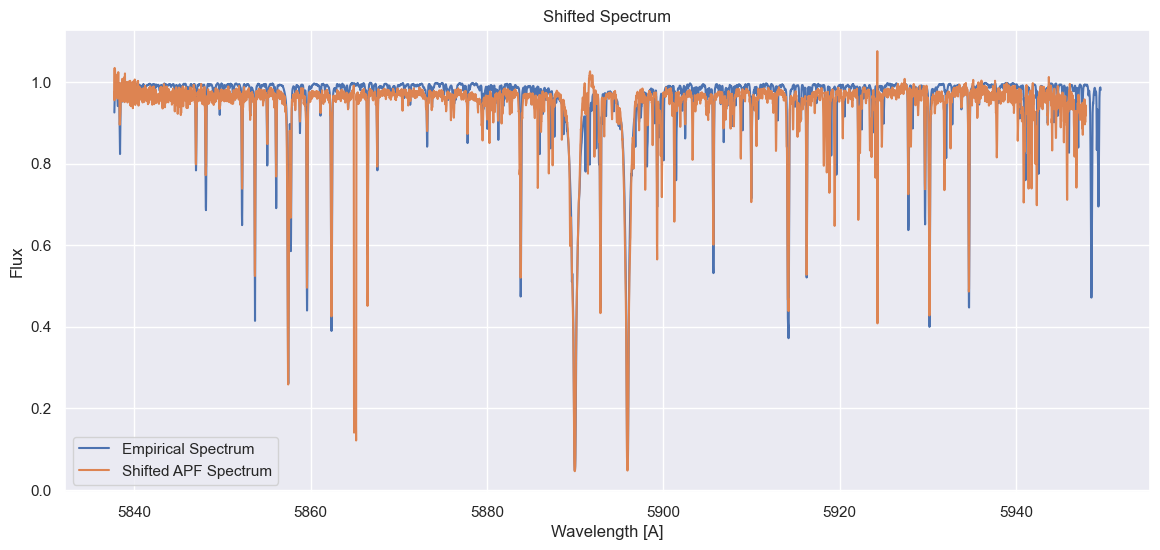

In [38]:
plt.plot(wl_syn_plot, fl_syn_plot, label = 'Empirical Spectrum')
plt.plot(shifted_wl, shifted_fl, label = 'Shifted APF Spectrum')

plt.title('Shifted Spectrum')
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.legend()
plt.show()

Zoom in to a smaller region of the plot to better visualize the difference.

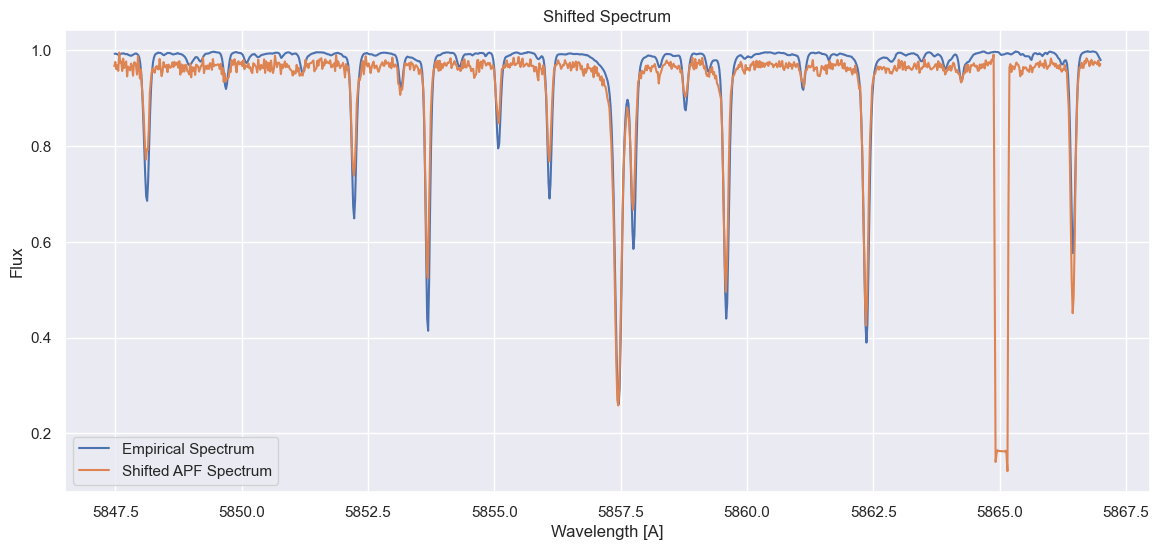

In [39]:
a = 500
b = 1500

plt.plot(wl_syn_plot[a:b], fl_syn_plot[a:b], label = 'Empirical Spectrum')
plt.plot(shifted_wl[a:b], shifted_fl[a:b], label = 'Shifted APF Spectrum')

plt.title('Shifted Spectrum')
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.legend()
plt.show()

that little weird drop on the right is from the flux_replacement array, so I'll go back and look at that in a bit! 

The residuals should be much lower.

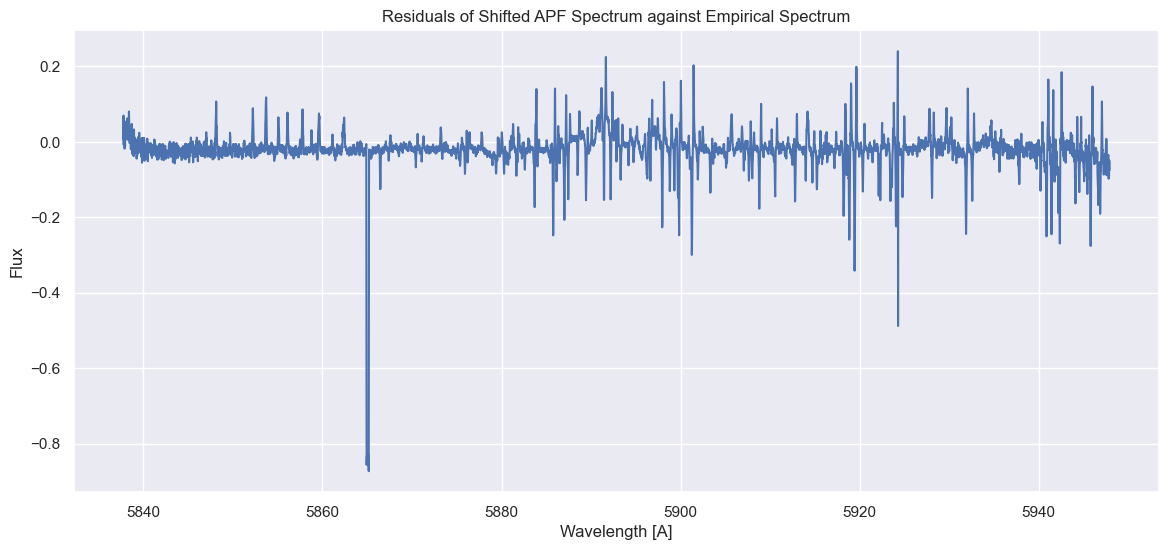

In [40]:
residuals_shifted = shifted_fl - fl_syn_plot[:len(shifted_wl)]
plt.plot(wl_syn_plot[:len(shifted_wl)], residuals_shifted)

plt.title('Residuals of Shifted APF Spectrum against Empirical Spectrum')
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.show()

## Final Product

Now we have a normalized, deblazed APF spectrum, shifted so that it is in its rest frame.

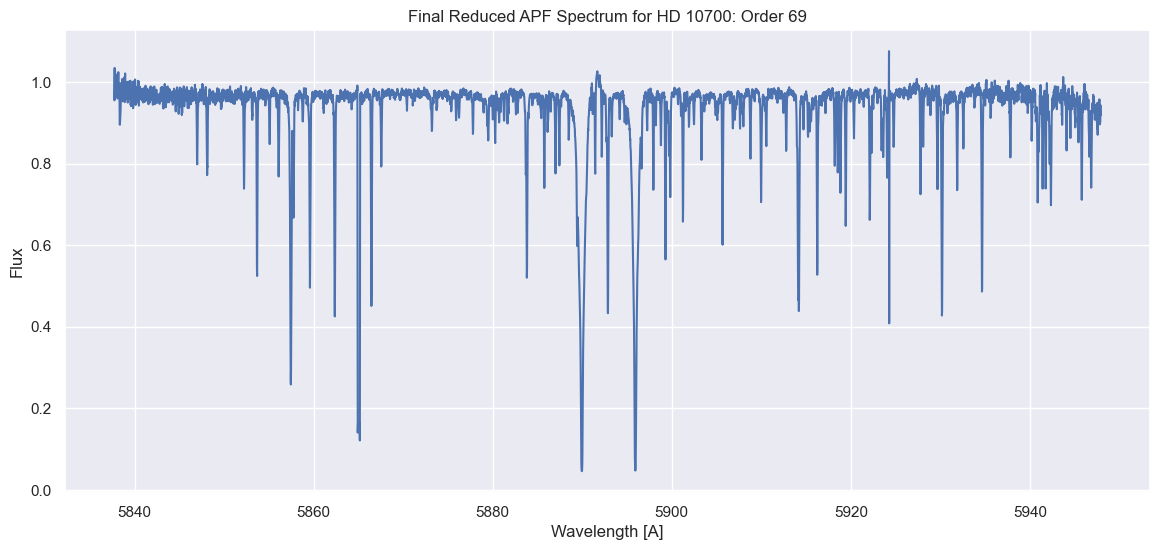

In [41]:
plt.plot(shifted_wl, shifted_fl)
plt.title('Final Reduced APF Spectrum for ' + star + ': Order ' + str(order))
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.show()

awesome looking good. the low drop at around 1865 is due to the replacement_flux array I made. I'll have to work on that a little more to see why it dropped so low even though i set it to be the mean flux for that region, so it would make more sense for the new flux values after being normalized to fall along the other values in that region. 

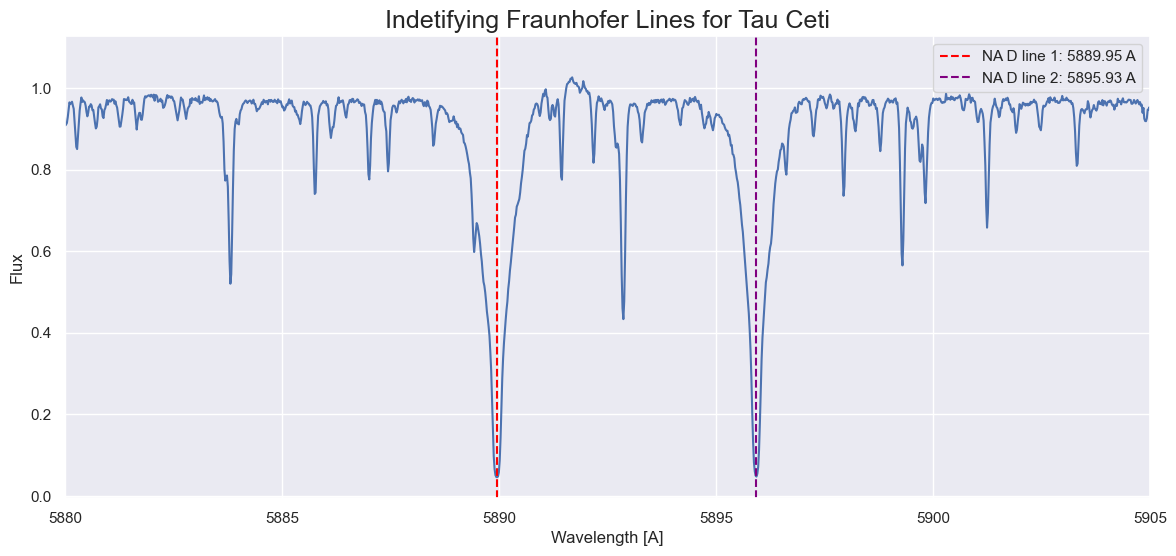

In [64]:
#zooming in to the target region for NA D lines:

plt.plot(shifted_wl, shifted_fl)
plt.xlim(5880,5905)

plt.title('Indetifying Fraunhofer Lines for Tau Ceti', fontsize = 18)
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')

#inserting asymptotes for fraunhofer lines 
plt.axvline(x = 5889.95, color = 'red',linestyle = 'dashed',label = 'NA D line 1: 5889.95 A')
plt.axvline(x = 5895.925, color = 'purple',linestyle = 'dashed',label = 'NA D line 2: 5895.93 A')
plt.legend()
plt.show()

the Sodium D lines lie where expected, so we can proceed to the next part of the process! 

## Gaussian Fit estimation for PSF 

In [43]:
#defining my general guassian function:
def gaussian(x,a, b, c):
    '''a is amplitude, b is  the mean (where i think it is), c is standard deviation (sqrt(variance))''' 
    return a*np.e**(-(x-b)**2/(2*c**2))

In [44]:
#amplitudes: 
a_1 = 0.5
a_2 = 0.55
a_3 = 0.25 
a_4 = 0.45
a_5 = 0.35

#mean values for gaussians
b_1 = 5883.815
b_2 = 5892.86
b_3 = 5897.95
b_4 = 5899.3
b_5 = 5901.24

#standard deviations (PSF in wavelength, so change into pixels)
c_1 = 0.08
c_2 = 0.09
c_3 = 0.035
c_4 = 0.05
c_5 = 0.05

In [45]:
x_gaussians = shifted_wl

gaussian_1 = gaussian(x_gaussians,a_1,b_1,c_1)
gaussian_2 = gaussian(x_gaussians,a_2,b_2,c_2)
gaussian_3 = gaussian(x_gaussians,a_3,b_3,c_3)
gaussian_4 = gaussian(x_gaussians,a_4,b_4,c_4)
gaussian_5 = gaussian(x_gaussians,a_5,b_5,c_5)

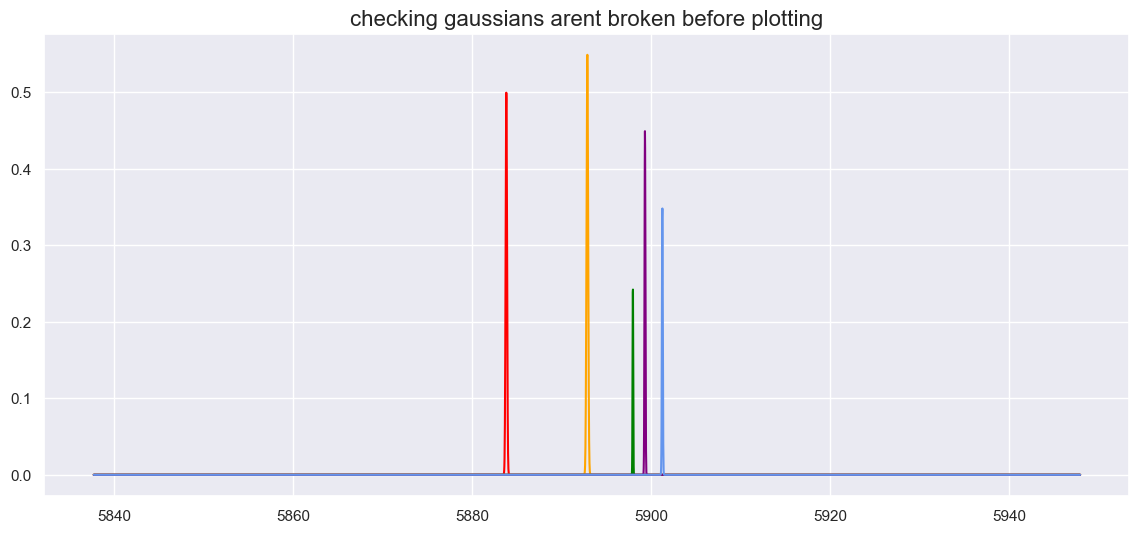

In [46]:
plt.plot(shifted_wl,gaussian_1, c = 'red')
plt.plot(shifted_wl,gaussian_2, c = 'orange')
plt.plot(shifted_wl,gaussian_3, c = 'green')
plt.plot(shifted_wl,gaussian_4, c = 'purple')
plt.plot(shifted_wl,gaussian_5,c = 'cornflowerblue')
plt.title('checking gaussians arent broken before plotting', fontsize = 16)
plt.show()

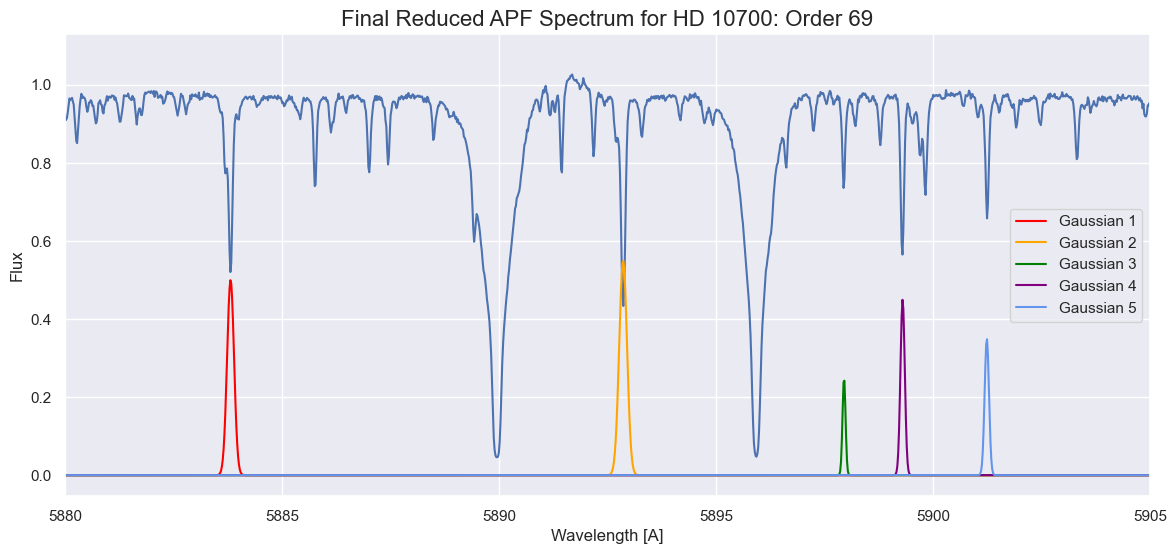

In [47]:
#plotting with gaussians:
plt.plot(shifted_wl, shifted_fl)
plt.xlim(5880,5905)
plt.title('Final Reduced APF Spectrum for ' + star + ': Order ' + str(order), fontsize = 16)
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')



#picking four lines to plot guassians for: 
# plt.axvline(x = b_1, color = 'red',linestyle = 'dashed',label = 'Gaussian 1')
# plt.axvline(x = b_2, color = 'orange',linestyle = 'dashed',label = 'Gaussian 2')
# plt.axvline(x = b_3, color = 'green',linestyle = 'dashed',label = 'Gaussian 3')
# plt.axvline(x = b_4, color = 'purple',linestyle = 'dashed',label = 'Gaussian 4')
# plt.axvline(x = b_5, color = 'pink',linestyle = 'dashed',label = 'Gaussian 4')


#add gaussians here 
plt.plot(shifted_wl,gaussian_1, c = 'red',label = 'Gaussian 1')
plt.plot(shifted_wl,gaussian_2, c = 'orange',label = 'Gaussian 2')
plt.plot(shifted_wl,gaussian_3, c = 'green',label = 'Gaussian 3')
plt.plot(shifted_wl,gaussian_4, c = 'purple',label = 'Gaussian 4')
plt.plot(shifted_wl,gaussian_5,c = 'cornflowerblue', label = 'Gaussian 5')

plt.legend()
plt.show()

## okie now time to plot gaussians 
Task:

_As a reminder, since the Gaia plots and Fraunhofer line plots should be completed, I want you to work on injecting Gaussian shaped "laser emission" lines in the spectra. Once you have a basic injection process working, trying injecting a series of lines at regularly spaced wavelengths. See how their separation compares to a set of injections into the delta-log-lambda wavelength solution. How does their spacing change in these two scenarios?_

### trying with the first guassian:
Plan: 

1. create a for loop that will create "copies" of the gaussian but adjust the mean value to change where it is plotted
2. plot all of them 
3. create a for loop that is now in terms of velocity


In [48]:
#just plot gaussian 1 for the kicks

parameters_1 = np.array([a_1,b_1,c_1])
#what is changing is b_1

#number of gaussians needed:
width_of_gaussian_1 = parameters_1[2]
range_of_wl = max(shifted_wl) - min(shifted_wl)
number_of_gaussian_1 = range_of_wl/width_of_gaussian_1//2 #divided by 2 since the mean lies at the middle of the gaussian

In [49]:
number_of_gaussian_1

688.0

In [50]:
#defining periodic gaussians: 

def periodic_gaussian(alpha,t,n,T): #put values in here idk what they are yet 
    '''alpha = amplitude i think
    t = range of values 
    n = something
    T = period of gaussian (distance between peaks)'''
    values = []
    summation = []
    
    for x in t:
        for y in n:
            summation = np.append(summation,np.e**(-(alpha**2)*(x-y*T)**2))
            summation = sum(summation)
        func =  alpha/np.sqrt(np.pi)*summation
        values = np.append(values,func)
    return values

## Periodic Gaussian Function 

<h2 style="text-align: center;">$ \sigma^2 e^{\frac{-2}{l^2}\frac{\sin(\pi (x-x'))}{p}^2}$</h2>

where:    
$\sigma$ = amplitude   
$l$ = vertical translation (1 = no translation)   
x = array of input parameters   
x' = horizontal translation (1 = no translation)    
p = period (determines the width of the gaussian)




In [51]:
def periodic_gaussian(sigma,l,x,xprime,p):
    exponent = []
    function = []
    for i in x:
        exponent = np.append(exponent,-2/l**2 * (np.sin(np.pi*(((i-xprime)/p))))**2)
    function = np.append(function,sigma**2 * np.e**exponent)
    return function


In [52]:
test_x = np.linspace(-10,10,1000)
test_gaussian2 = periodic_gaussian(1,1,test_x,1,10)
test_gaussian3 = periodic_gaussian(1,1,test_x,5.5,10)

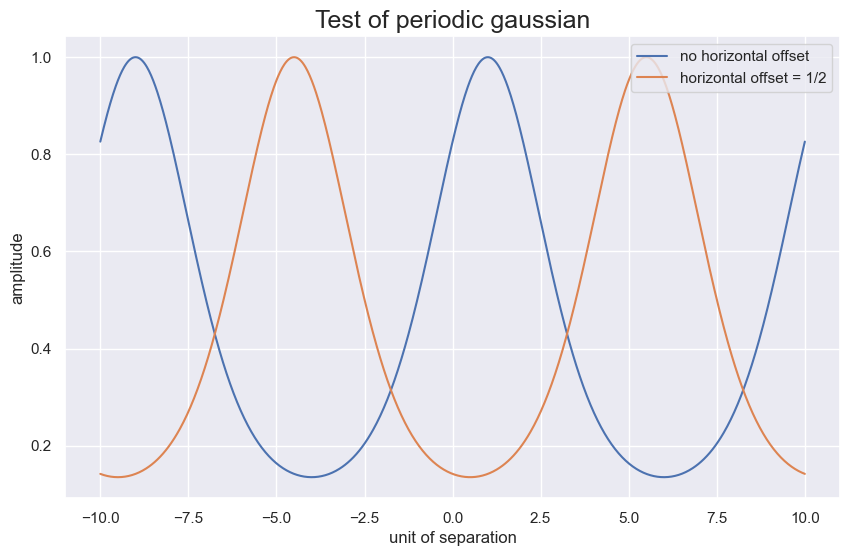

In [53]:
plt.figure(figsize=(10,6))
plt.plot(test_x,test_gaussian2, label = 'no horizontal offset')
plt.plot(test_x,test_gaussian3, label = 'horizontal offset = 1/2')
plt.title('Test of periodic gaussian', fontsize = 18)
plt.xlabel('unit of separation')
plt.ylabel('amplitude')
plt.legend(loc = 'upper right')
plt.show()

In [54]:
#test with dataset:

#doing gaussian 1 when possible 
gaussian_with_dataset = periodic_gaussian(a_1*2.9/2,l = 1,x = shifted_wl,xprime = b_1-.01, p = 0.8) *-1 +1.05
gaussian_with_dataset_2 = periodic_gaussian(a_2,l=1,x = shifted_wl,xprime = b_2, p = 2.5)

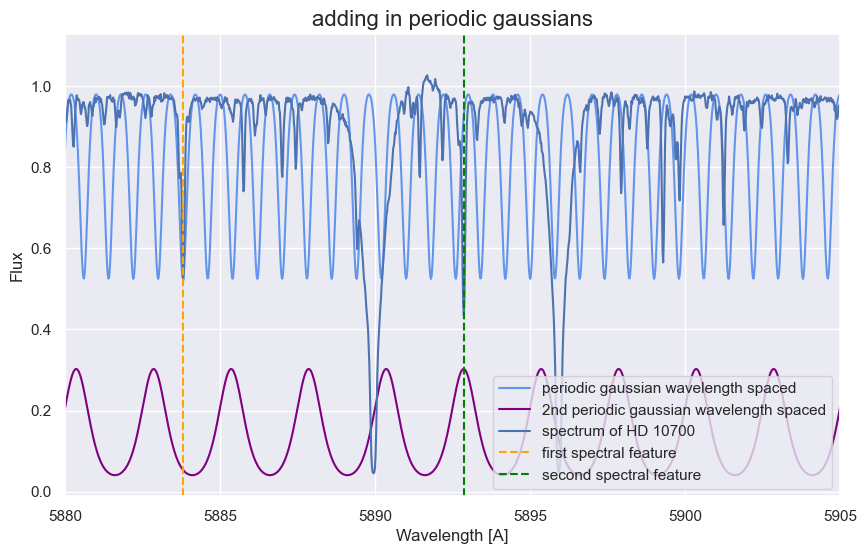

In [55]:
#plotting in regards to shifted_wl values 
plt.figure(figsize=(10,6))

plt.plot(shifted_wl,gaussian_with_dataset, color = 'cornflowerblue',label = 'periodic gaussian wavelength spaced')
plt.plot(shifted_wl,gaussian_with_dataset_2, color = 'purple',label = '2nd periodic gaussian wavelength spaced')
plt.plot(shifted_wl, shifted_fl, color = 'b', label = 'spectrum of HD 10700')

plt.axvline(x = b_1, color = 'orange',linestyle = 'dashed',label = 'first spectral feature')
plt.axvline(x = b_2, color = 'green',linestyle = 'dashed',label = 'second spectral feature')

plt.xlim(5880,5905)
plt.title('adding in periodic gaussians', fontsize = 16)
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.legend(loc = 'lower right')

plt.show()

In [56]:
#for meeting on 3/13: 

notes: 
    
read carol and ostlie on spectral lines: 5.1 

and chapter 9: the struture of spectral lines 

"the curve of growth: - section 9.4 
"equivalent width" - shapes and widths of spectral lines

"voigt profile"


for next time:
1. plot the chi squared function for the shifted wavelength solution and see the goodness of fit (plot next to each other) 
2. plot the gaussians with twice the spacing to make it less crowded 


personal goals: 
1. create a fit for the gaussians instead of guestimating 
2. shift it up to be inline with the plot 

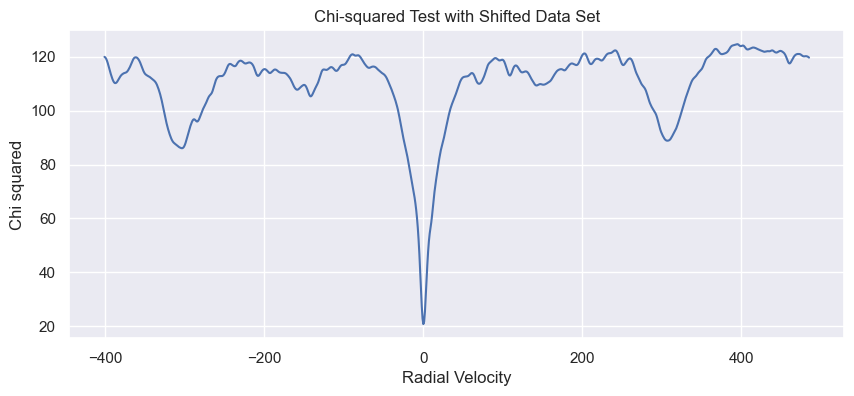

HD 10700 is traveling away from Earth at 0 km/s. The APF spectrum needs to be blueshifted by 0 pixels. (Shift to right.)


In [61]:
# #plotting the chi squared for the shifted wl and flux values to test the accurancy of this method: 
# changing all values so that things dont get messed up 
chi_squared_comparison_values = []
indices_comparison = []

# data sets are synth and shifted wl 
# shifted_wl
# shifted_fl

for i in np.arange(len(wl_syn) - len(shifted_wl)): #changing wl to wl2
    syn_flux = fl_syn[i: i + len(shifted_wl)]
    chi_squared_comparison = chi(syn_flux, shifted_fl) #changing to flux2
    chi_squared_comparison_values = np.append(chi_squared_comparison_values, chi_squared_comparison)
    indices_comparison = np.append(indices_comparison, i)
    
min_chi_comparison = min(chi_squared_comparison_values)
shifted_index_comparison = chi_squared_comparison_values.tolist().index(min_chi_comparison)
plt.figure(figsize = (10,4))
plt.plot(indices_comparison - index, chi_squared_comparison_values)
plt.xlabel('Radial Velocity')
plt.ylabel('Chi squared')
plt.title('Chi-squared Test with Shifted Data Set')
plt.show()

if (shifted_index_comparison - index) < 0: #index = wl_syn.tolist().index(w)
    shift_comparison = index - shifted_index_comparison
    print(star + ' is traveling toward Earth at ' + str(shift_comparison) + ' km/s. The APF spectrum needs to be redshifted by ' + str(shift_comparison) + ' pixels. (Shift to left.)')
    shift_dir = 'left'
else:
    shift_comparison = shifted_index_comparison - index
    print(star + ' is traveling away from Earth at ' + str(shift_comparison) + ' km/s. The APF spectrum needs to be blueshifted by ' + str(shift_comparison) + ' pixels. (Shift to right.)')
    shift_dir = 'right'

In [58]:
#end of chi squared testing #

### Exporting data to csv for further analysis in a different notebook

In [59]:
import pandas as pd
data_2darray = {'shifted wavelength':shifted_wl, 'shifted flux': shifted_fl}
data_set = pd.DataFrame(data_2darray)

data_set

,shifted wavelength,shifted flux
0,5837.733295,0.975411
1,5837.752767,0.955095
2,5837.772240,1.034401
3,5837.791713,0.967296
4,5837.811185,1.029852
...,...,...
5601,5947.824252,0.931084
5602,5947.844092,0.901381
5603,5947.863932,0.943624
5604,5947.883772,0.941895


In [60]:
#hopefully it exports
data_set.to_csv('C:\\Users\\alica\\workspace\\Fraunhofer Line Drafts\\tau_ceti_shifted_values.csv')


OSError: Cannot save file into a non-existent directory: 'C:\Users\alica\workspace\Fraunhofer Line Drafts'